# RedisAI Monitoring Demo

RedisAI Monitoring Demo using TorchDrift

## Download and setup data

In [1]:
import torchvision
import torch

torchvision.datasets.utils.download_and_extract_archive('https://download.pytorch.org/tutorial/hymenoptera_data.zip', 'data/')
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])


dset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val/', transform=val_transform)
labels = {309: "Bee", 310: "Ant"}

Using downloaded and verified file: data/hymenoptera_data.zip
Extracting data/hymenoptera_data.zip to data/


In [2]:
import redisai
import numpy as np
import ml2rt

con = redisai.Client()

def init():
    state = np.zeros((1, 1))
    con.tensorset('state', state)

    user_model = ml2rt.load_model('user_model.pt')
    con.modelset('user-model', data=user_model, backend='TORCH', device='cpu')

    drift_model = ml2rt.load_model('wrapped_detector.pt')
    con.modelset('drift-model', data=drift_model, backend='TORCH', device='cpu')

    script = ml2rt.load_script("script.py")
    con.scriptset("drift-script", device='cpu', script=script)

init()

In [3]:
def run_redisai(image):
    con.tensorset('image', image)
    con.modelrun('user-model', inputs='image', outputs=['classes', 'features'])
    con.scriptrun('drift-script', 'accumulate', inputs=['state', 'features'], outputs='state')
    con.modelrun('drift-model', inputs=['state'], outputs=['p_value'])
    con.scriptrun('drift-script', 'push_statistics', inputs=['state', 'p_value'], outputs=[])

## RedisAI calls with non-drifted data

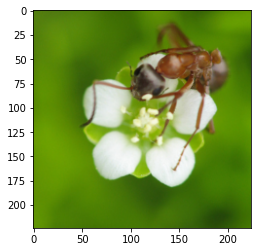

In [4]:
from matplotlib import pyplot as plt
import time
from IPython import display
import random

for i in range(0, 20):
    display.clear_output(wait=True)
    image = dset[i][0].unsqueeze(0)
    plt.imshow(image.squeeze().permute(1, 2, 0))
    plt.show()
    image = image.numpy()
    run_redisai(image)
    time.sleep(1)

## RedisAI calls with drifted-data

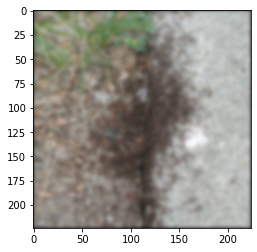

In [5]:
import torchdrift

for i in range(0, 22):
    display.clear_output(wait=True)
    image = dset[i][0].unsqueeze(0)
    image = torchdrift.data.functional.gaussian_blur(image, severity=2)
    plt.imshow(image.squeeze().permute(1, 2, 0))
    plt.show()
    image = image.numpy()
    run_redisai(image)
    time.sleep(1)